In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = 25
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1.6
mpl.rcParams['ytick.major.width'] = 1.6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3

In [2]:
from ulens_parallax import Lensing
import pymc as pm
import arviz as az
import numpy as np
import astropy.units as u

## The `Lensing` Class & Mocking Data

In [3]:
T_today = 59845 + .5 - 50000 # JD - 2450000
n_obs = 800
T = (np.linspace(T_today, T_today + n_obs, n_obs) + np.random.randn(n_obs) * 0.1)
params = {
    'RA':0, 'Dec':0,
    'Fs':1, 'Fb':0,
    'T0':(T_today + 300),
    'TP':(T_today + 300),
    'u0':0.4,
    'tE':80,
    'PiEN':0.2, 'PiEE':0.1
}
lens = Lensing(T, **params)

In [4]:
t_mock = (np.linspace(T_today, T_today + n_obs, n_obs//5) + np.random.randn(n_obs//5) * 0.3)
F_sig_mock = (np.random.rand(len(t_mock)) - 0.5) / 10
F_sig_sys = 0.1
F_mock = lens.predict(t_mock) + F_sig_mock + np.random.randn(len(t_mock)) * F_sig_sys

<ErrorbarContainer object of 3 artists>

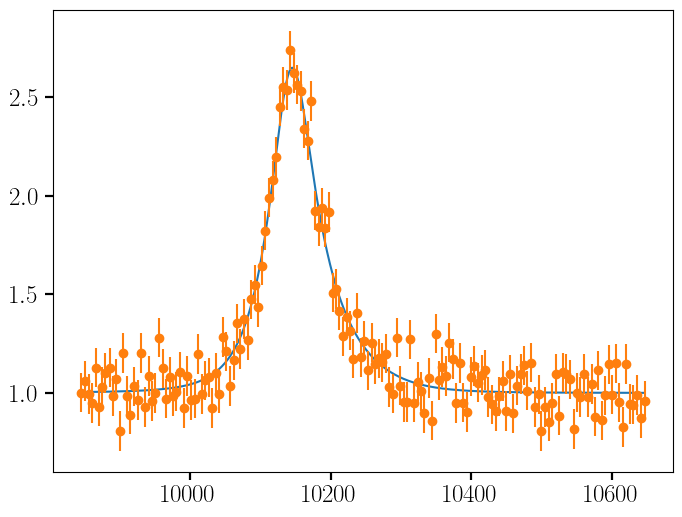

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T, lens.predict(T))
ax.errorbar(t_mock, F_mock, yerr=F_sig_sys, fmt='o')
#ax.invert_yaxis()

## PyMC

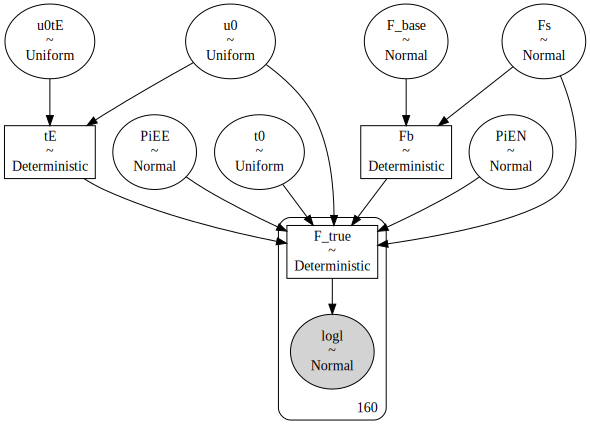

In [11]:
with pm.Model() as model:
    
    # priors
    Fbase = pm.Normal('F_base', 1, 0.05)
    Fs = pm.Normal('Fs', 1, 0.05)
    Fb = pm.Deterministic('Fb', Fbase - Fs)
    t0 = pm.Uniform('t0', lower=10100., upper=10300., initval=10200)
    u0 = pm.Uniform('u0', lower=0.01, upper=1., initval=0.5)
    u0tE = pm.Uniform('u0tE', lower=0., upper=1000., initval=30)
    tE = pm.Deterministic('tE', u0tE/u0)
    PiEN = pm.Normal('PiEN', 0, 1)
    PiEE = pm.Normal('PiEE', 0, 1)
    

    params = {
        'RA':0, 'Dec':0,
        'Fs':Fs, 'Fb':Fb,
        'T0':t0,
        'TP':(T_today + 300),
        'u0':u0,
        'tE':tE,
        'PiEN':PiEN, 'PiEE':PiEE
    }
    lens_model = Lensing(T, **params)
    F_true = pm.Deterministic('F_true', lens_model.predict(t_mock))
    
    # log_likelihood
    pm.Normal('logl', mu=F_true, sigma=F_sig_sys, observed=F_mock)

pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F_base, Fs, t0, u0, u0tE, PiEN, PiEE]


/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8976, but should be close to 0.8. Try to increase the number of tuning steps.


In [13]:
az.summary(idata, var_names=['u0','u0tE', 't0', 'PiEN', 'PiEE'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u0,0.300,0.170,0.000,0.419,0.085,0.065,7.0,31.0,1.53
u0tE,29.358,17.802,0.033,50.339,8.249,6.243,7.0,31.0,1.54
t0,10163.589,30.174,10142.938,10218.219,14.990,11.473,7.0,31.0,1.53
PiEN,0.556,1.314,-0.751,2.833,0.620,0.496,7.0,33.0,1.54
PiEE,-0.098,0.531,-1.170,0.420,0.252,0.192,7.0,30.0,1.54


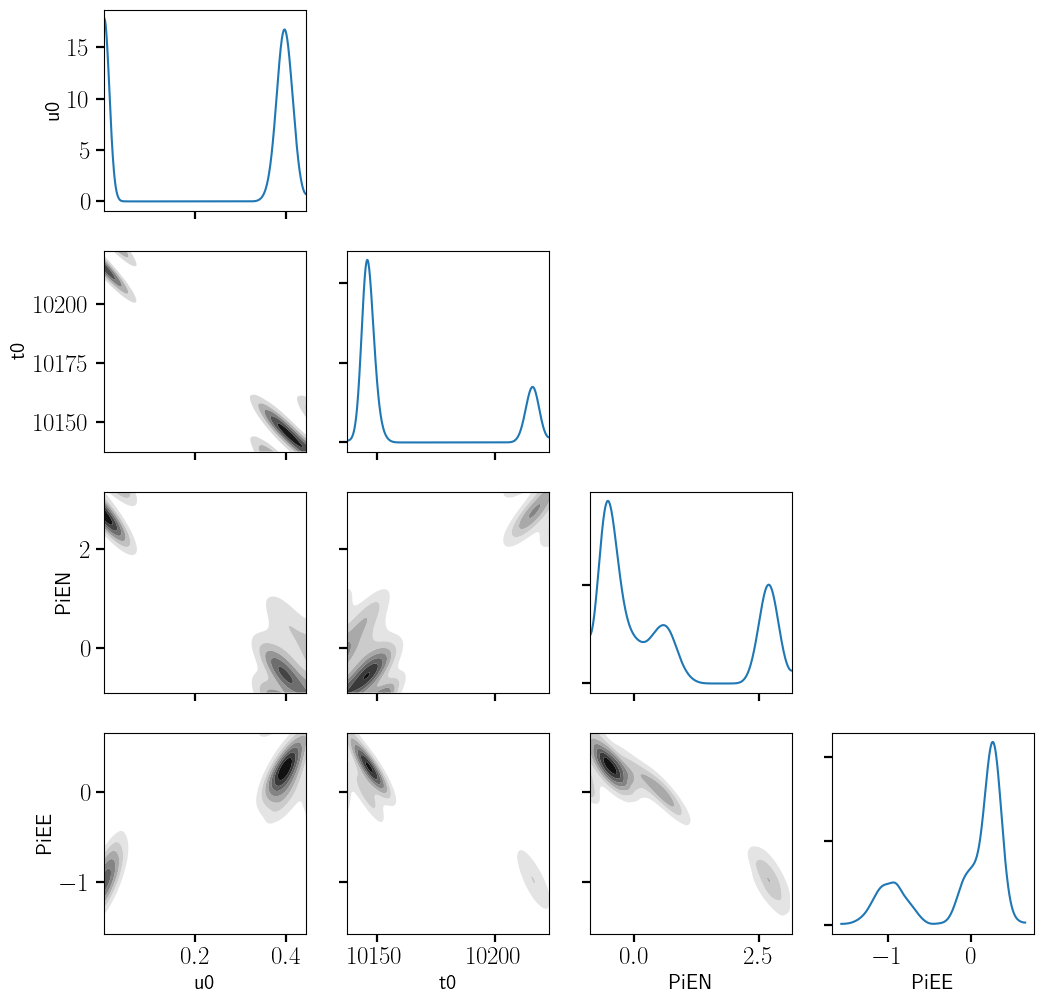

In [14]:
az.plot_pair(
    idata, 
    var_names=['u0', 't0','PiEN','PiEE'], 
    marginals=True,
    kind="kde",
    kde_kwargs=dict(contourf_kwargs=dict(cmap="Greys"), contour_kwargs=dict(alpha=0.0)),
    figsize=(12, 12)
)
plt.show()

## Real Data

<ErrorbarContainer object of 3 artists>

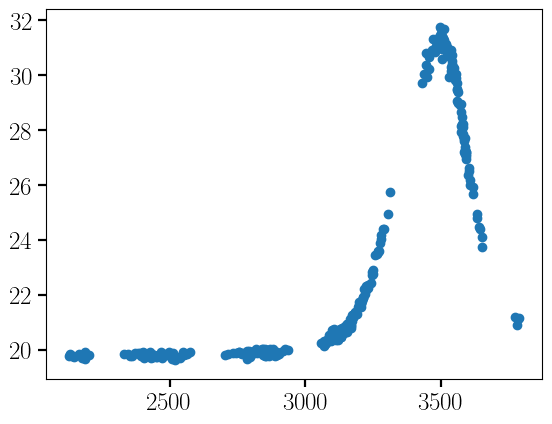

In [64]:
obs = np.loadtxt('phot.dat')
t_obs = obs[:, 0] - 2450000
mag, mag_err = obs[:, 1], obs[:, 2]

fl = 10**(-0.4 * (mag - 18)) 
fl_unc = (10**(-0.4 * (mag - mag_err - 18)) - 10**(-0.4 * (mag +mag_err - 18)))/2

plt.errorbar(t_obs, fl, yerr=fl_unc, fmt='o')
#plt.xlim(3450, 3550)
#plt.ylim(30, 32)

In [19]:
np.mean(fl[t_obs < 2700]), np.std(fl[t_obs < 2700], ddof=1)

(19.79079962930876, 0.07076531209512701)

In [83]:
from random import sample


with pm.Model() as model_obs:
    
    # priors
    Fbase = pm.Normal('F_base', 19.79, 0.1)
    Fb = pm.HalfNormal('Fb', 0.1)
    Fs = pm.Deterministic('Fs', Fbase - Fb)
    #t0 = pm.Uniform('t0', lower=3400., upper=3600., initval=3500)
    t0 = pm.TruncatedNormal('t0', 3500, 10, lower=3400, upper=3600)
    u02 = pm.Uniform('u02', lower=0.01, upper=1.4, initval=0.5)
    u0 = pm.Deterministic('u0', u02**.5)
    u0tE = pm.Uniform('u0tE', lower=10, upper=1000., initval=100)
    tE = pm.Deterministic('tE', u0tE/u0)
    PiEN = pm.Normal('PiEN', 0, 0.1)
    PiEE = pm.Normal('PiEE', 0, 0.1)
    

    params = {
        'RA':266.6458, 'Dec':-33.7719,
        'Fs':Fs, 'Fb':Fb,
        'T0':t0,
        'TP':3500,
        'u0':u0,
        'tE':tE,
        'PiEN':PiEN, 'PiEE':PiEE
    }
    lens_model = Lensing(T, **params)
    F_true = pm.Deterministic('F_true', lens_model.predict(t_obs))
    
    # log_likelihood
    pm.Normal('logl', mu=F_true, sigma=fl_unc, observed=fl)

    idata_obs = pm.sample(tune=5000, draws=3000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F_base, Fb, t0, u02, u0tE, PiEN, PiEE]


/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chang/miniconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 5_000 tune and 3_000 draw iterations (20_000 + 12_000 draws total) took 39 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or

In [91]:
az.summary(idata_obs, var_names=['u0', 't0','F_base', 'Fs', 'PiEN', 'PiEE'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u0,0.760,0.001,0.758,0.762,0.000,0.000,473.0,156.0,1.01
t0,3501.444,0.211,3501.071,3501.859,0.005,0.004,1637.0,2134.0,1.00
F_base,19.732,0.005,19.723,19.742,0.000,0.000,5968.0,7081.0,1.00
Fs,19.675,0.050,19.581,19.738,0.003,0.002,493.0,158.0,1.01
PiEN,0.092,0.002,0.088,0.095,0.000,0.000,5843.0,6133.0,1.00
PiEE,-0.039,0.001,-0.041,-0.037,0.000,0.000,3840.0,6252.0,1.00


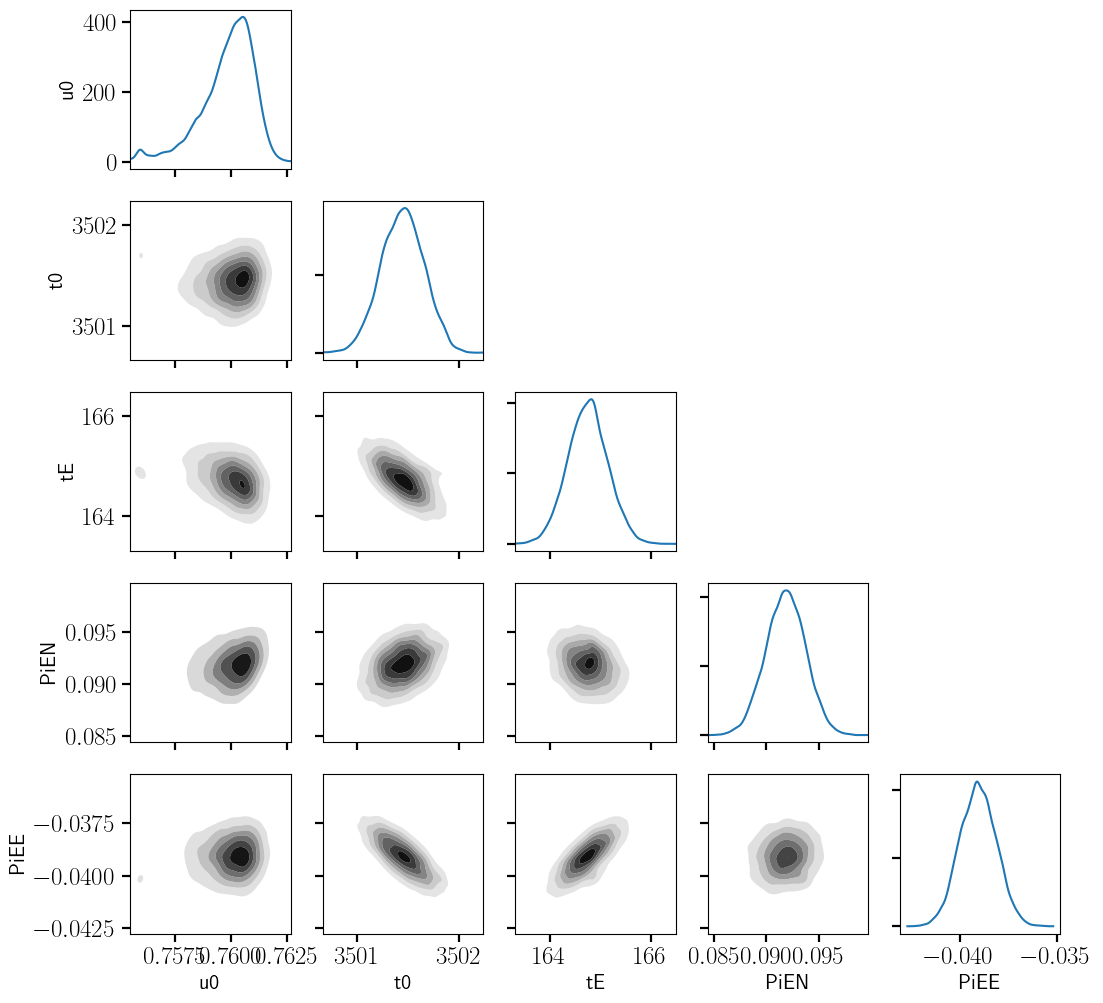

In [85]:
az.plot_pair(
    idata_obs, 
    var_names=['u0', 't0','tE', 'PiEN','PiEE'], 
    marginals=True,
    kind="kde",
    kde_kwargs=dict(contourf_kwargs=dict(cmap="Greys"), contour_kwargs=dict(alpha=0.0)),
    figsize=(12, 12)
)
plt.show()

(2800.0, 3700.0)

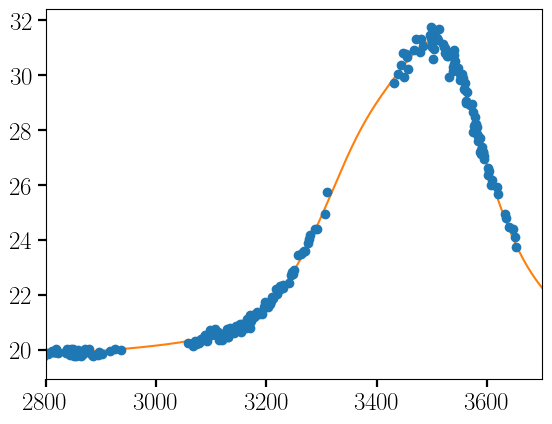

In [95]:
plt.errorbar(t_obs, fl, yerr=fl_unc, fmt='o')
res = az.summary(idata_obs)
params_best = {
    'RA':266.6458, 'Dec':-33.7719,
    'Fs':res['mean']['Fs'], 'Fb':res['mean']['Fb'],
    'T0':res['mean']['t0'],
    'TP':3500,
    'u0':res['mean']['u0'],
    'tE':res['mean']['tE'],
    'PiEN':res['mean']['PiEN'], 'PiEE':res['mean']['PiEE']
}
t_model = np.linspace(t_obs[0], t_obs[-1], 1000)
lens_model = Lensing(t_model, **params_best)
plt.plot(t_model, lens_model.predict(t_model))
plt.xlim(2800, 3700)